In [1]:
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
#keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
np.random.seed(101)

In [5]:
df = pd.read_csv('../data/cleaned_data.csv').drop('Unnamed: 0',axis=1)

In [6]:
#df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
def filename_appender(df):
    df.fname = df.fname.apply(lambda x: '../img/' + x + '.jpg')
    return df

In [8]:
#df = filename_appender(df)

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('code',axis=1)

y = df.code

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1)

In [10]:
# The format specification here left pads zeros on the number: 0004.
train_filenames = [fname for fname in X_train.fname]
val_filenames = [fname for fname in X_val.fname]
test_filenames = [fname for fname in X_test.fname]

In [11]:
df.to_csv('../data/cleaned_data.csv')

## Preparing datasets
### Finding and deleting corrupted images that Tensorflow cannot handle

In [12]:
def reset_indices(arr):
    arr.reset_index(drop=True,inplace=True)
    return arr

In [13]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [150, 150])
    image /= 255.0
    return image

def remove_corrupt_files(filenames,y_arr):
    imgs = []
    
    y_arr = reset_indices(y_arr)
    for i,filename in enumerate(filenames):        
        # Try reading, decoding, resizing and normalizing images
        # Only appends files that do not cause any errors to an 'imgs' list
        try:
            img = load_and_preprocess_image(filename)
            imgs.append(np.asarray(img))  

            # If error occurs, skip to the next file and remove the file from the y array using its index
        except:
            
            del y_arr[i]
            continue
              
    X = np.asarray(imgs)
    y = np.asarray(y_arr)
    
    return X, y

In [14]:
X_train_f,y_train_f = remove_corrupt_files(train_filenames,y_train)
X_val_f,y_val_f = remove_corrupt_files(val_filenames,y_val)
X_test_f,y_test_f = remove_corrupt_files(test_filenames,y_test)

## Training the tensorflow model

In [15]:
# from tensorflow.keras import backend as K
# img_width, img_height = 150, 150
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)

In [16]:
from tensorflow.keras import backend as K
img_width, img_height = 150, 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [17]:
# # Change to be committed after fitting is complete
# model = keras.models.Sequential()
# model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(input_shape), padding='same'))
# model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(keras.layers.Conv2D(96, (3, 3),activation = 'relu', padding='same'))
# model.add(keras.layers.Conv2D(96, (3, 3),activation = 'relu', padding='same'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))


# model.add(keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(keras.layers.Dense(256, activation = 'relu'))
# model.add(keras.layers.Dropout(0.8))
# model.add(keras.layers.Dense(10, activation = 'softmax'))
# #new_model.add(keras.layers.Dense(10,  activation = "softmax"))

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(input_shape),activation='relu'))
model.add(Conv2D(32, (3, 3), input_shape=(input_shape),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.5))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Activation('softmax'))

optimizer = SGD(lr=0.005, momentum=0.9)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        9248      
_________________________________________________________________
activation (Activation)      (None, 69, 69, 32)        0

In [20]:
#optimizer = Adam(lr=0.001)
#opt = SGD(lr=0.005, momentum=0.9)

In [21]:
from tensorflow.keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.001, mode= 'min', patience=5),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0,
    min_delta=0.001, cooldown=1, min_lr=0, mode = 'min'),
    callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
]

In [ ]:
filepath="../checkpoints/base_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
from tensorflow.keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(monitor='loss', mode= 'min', patience=5),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0,
    min_delta=0.001, cooldown=1, min_lr=0, mode = 'min')

In [23]:
history = model.fit(X_train_f, y_train_f, epochs=25,
         validation_data=(X_val_f,y_val_f))

Epoch 1/25
321/321 [==============================] - 98s 306ms/step - loss: 2.4860 - accuracy: 0.0806 - val_loss: 2.4867 - val_accuracy: 0.0693
Epoch 2/25
321/321 [==============================] - 98s 305ms/step - loss: 2.4855 - accuracy: 0.0823 - val_loss: 2.4863 - val_accuracy: 0.0693
Epoch 3/25
321/321 [==============================] - 97s 304ms/step - loss: 2.4855 - accuracy: 0.0788 - val_loss: 2.4860 - val_accuracy: 0.0693
Epoch 4/25
321/321 [==============================] - 98s 304ms/step - loss: 2.4854 - accuracy: 0.0806 - val_loss: 2.4862 - val_accuracy: 0.0693
Epoch 5/25
321/321 [==============================] - 98s 305ms/step - loss: 2.4854 - accuracy: 0.0841 - val_loss: 2.4861 - val_accuracy: 0.0693
Epoch 6/25
321/321 [==============================] - 98s 305ms/step - loss: 2.4854 - accuracy: 0.0820 - val_loss: 2.4859 - val_accuracy: 0.0693
Epoch 7/25
321/321 [==============================] - 98s 306ms/step - loss: 2.4853 - accuracy: 0.0854 - val_loss: 2.4858 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(X_test_f, y_test_f, verbose=0)

print('\nTest accuracy {:5.2f}%'.format(100*test_acc))


Test accuracy  7.52%


## Visualize the model

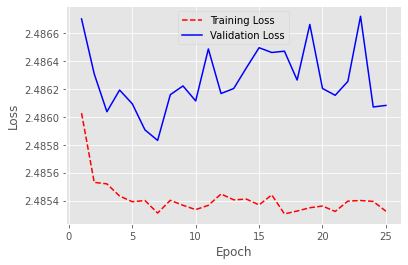

In [28]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1,len(training_loss)+1)

plt.plot(epoch_count,training_loss,'r--')
plt.plot(epoch_count,test_loss,'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

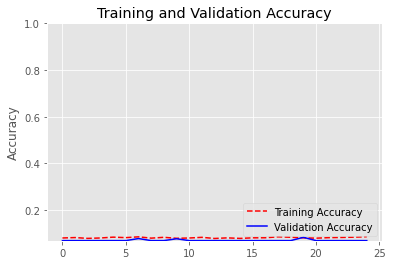

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1,len(training_loss)+1)

plt.plot(acc, 'r--', label='Training Accuracy')
plt.plot(val_acc, 'b-', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy');
